<a href="https://colab.research.google.com/github/therishabhmittal-05/Pytorch/blob/main/pytorch_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import torchvision

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download=True,  transform=transform)
testset = torchvision.datasets.CIFAR10(root='/data',  train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]
100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


In [5]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)


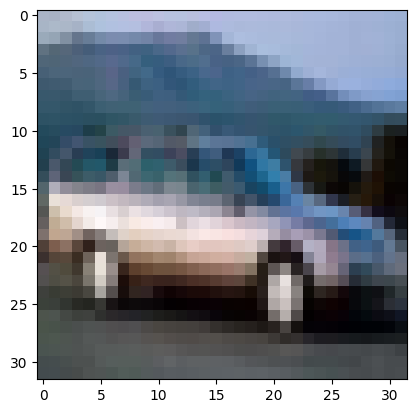

1


In [6]:
import matplotlib.pyplot as plt
plt.imshow(trainset.data[4])
plt.show()
print(trainset.targets[4])

In [7]:
class CIFAR_10(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        # input -> (3, 32, 32)
        nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
        # output -> (64, 32, 32)
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
        # output -> (128, 32, 32)
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.MaxPool2d(kernel_size=2,stride=2)
        # output -> (128, 16, 16)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128*16*16, 8192),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(8192, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.features(x)
    logits = self.classifier(x)
    return logits

In [16]:
class Alex_CIFAR_10(nn.Module):
    def __init__(self):
        super(Alex_CIFAR_10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Smaller kernel
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 -> 16

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 -> 8

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8 -> 4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        logits = self.classifier(x)
        return logits


In [17]:
# model = CIFAR_10().to(device)
model = Alex_CIFAR_10().to(device)

lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
print(model.parameters())

<generator object Module.parameters at 0x7de895ca3bc0>


In [19]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 192, 16, 16]         110,784
              ReLU-5          [-1, 192, 16, 16]               0
         MaxPool2d-6            [-1, 192, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         663,936
              ReLU-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         884,992
             ReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
          Dropout-14                 [-

In [20]:
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = lossfn(yhat, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(trainloader.dataset)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{n_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {accuracy:.2f}%")

Epoch [1/10] - Loss: 1.7303 - Accuracy: 50.10%
Epoch [2/10] - Loss: 1.3345 - Accuracy: 57.97%
Epoch [3/10] - Loss: 1.1650 - Accuracy: 59.47%
Epoch [4/10] - Loss: 1.0692 - Accuracy: 61.37%
Epoch [5/10] - Loss: 0.9944 - Accuracy: 67.37%
Epoch [6/10] - Loss: 0.9402 - Accuracy: 68.93%
Epoch [7/10] - Loss: 0.8917 - Accuracy: 69.41%
Epoch [8/10] - Loss: 0.8473 - Accuracy: 69.12%
Epoch [9/10] - Loss: 0.8156 - Accuracy: 71.75%
Epoch [10/10] - Loss: 0.7832 - Accuracy: 70.63%


In [21]:
torch.save(model.state_dict(), "cifar10model.pth")

In [14]:

# for epoch in range(n_epochs):
#   for inputs, labels in trainloader:
#     inputs, labels = inputs.to(device), labels.to(device)
#     yhat = model(inputs)
#     loss = lossfn(yhat, labels)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#   acc = 0
#   count = 0
#   for inputs, labels in testloader:
#       y_pred = model(inputs)
#       acc += (torch.argmax(y_pred, 1) == labels).float().sum()
#       count += len(labels)
#   acc /= count
#   print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))